In [1]:
import sys
sys.path.append("../gaia_tools/")
sys.path.append("../scripts/")
import covariance_generation
import transformation_constants
import data_analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

dr3_path = '/local/mariacst/2022_v0_project/data/GaiaDR3_RV_RGB_fidelity.csv'
dr3_path ='/home/svenpoder/DATA/Gaia_DR3/GaiaDR3_RV_RGB_fidelity.csv'
gaia_dr3 = pd.read_csv(dr3_path)

r_est_error = (gaia_dr3.B_rpgeo - gaia_dr3.b_rpgeo)/2
gaia_dr3['r_est_error'] = r_est_error

columns_to_drop = ['Unnamed: 0', 'Vbroad', 'GRVSmag', 'Gal', 'Teff', 'logg',
       '[Fe/H]', 'Dist', 'A0', 'RAJ2000', 'DEJ2000', 'e_RAJ2000', 'e_DEJ2000',
       'RADEcorJ2000', 'B_Teff', 'b_Teff', 'b_logg', 'B_logg', 'b_Dist',
       'B_Dist', 'b_AG', 'B_AG', 'b_A0', 'B_A0', 'Gmag', 'BPmag', 'RPmag', 'BP-RP']
gaia_dr3 = gaia_dr3.drop(columns=columns_to_drop)

parallax_over_error = gaia_dr3.parallax/gaia_dr3.parallax_error
gaia_dr3['parallax_over_error'] = parallax_over_error

print(gaia_dr3.columns)

def load_galactic_parameters():
   '''The load_galactic_parameters function sets the initial galactocentric distance, height over the Galactic plane, and solar vector used in the coordinate transformations.'''

   # Initial Galactocentric distance
   r_0 = 8277

   # Initial height over Galactic plane
   z_0 = 25

   # Initial solar vector
   v_sun = transformation_constants.V_SUN
   v_sun[0][0] = 11.1
   v_sun[1][0] = 251.5
   v_sun[2][0] = 8.59

   return r_0, z_0, v_sun

def apply_initial_cut(icrs_data):

   r_0, z_0, v_sun = load_galactic_parameters()

   galcen_data = data_analysis.get_transformed_data(icrs_data,
                                          include_cylindrical = True,
                                          z_0 = z_0,
                                          r_0 = r_0,
                                          v_sun = v_sun,
                                          debug = True,
                                          is_bayes = True,
                                          is_source_included = True)

   print("Galactocentric data shape: {}".format(galcen_data.shape))

   galactocentric_cov = covariance_generation.generate_galactocentric_covmat(icrs_data, 
                                                               is_bayes = True,
                                                               Z_0 = z_0,
                                                               R_0 = r_0)

   cyl_cov = covariance_generation.transform_cov_cylindirical(galcen_data, 
                                                C = galactocentric_cov,
                                                Z_0 = z_0,
                                                R_0 = r_0)
   galcen_data = galcen_data.merge(cyl_cov, on='source_id')

   print("Galactocentric data shape after merge with covariance info: {}".format(galcen_data.shape))

   # Remove noisy distances
   print("Removing noisy distances")
   galcen_data['parallax_over_error'] = icrs_data.parallax_over_error[galcen_data.source_id == icrs_data.source_id]
   galcen_data = galcen_data[galcen_data.parallax_over_error > 5]
   galcen_data = galcen_data.drop(columns=['parallax_over_error'])

   print("Galactocentric data shape after removing noisy distances: {}".format(galcen_data.shape))

   # Final data cut
   galcen_data = galcen_data[(galcen_data.r < 15000) & (galcen_data.r > 5000)]
   print("Galactocentric data shape after constraining region in r: {}".format(galcen_data.shape))
   galcen_data = galcen_data[(galcen_data.z < 200) & (galcen_data.z > -200)]
   print("Galactocentric data shape after constraining region in z: {}".format(galcen_data.shape))

   # Remove halo stars (condition taken from 1806.06038)                        
   v_dif = np.linalg.norm(np.array([galcen_data.v_x, galcen_data.v_y, galcen_data.v_z])-v_sun,
                        axis=0)                                               
   galcen_data['v_dif'] = v_dif                                                 
   galcen_data = galcen_data[galcen_data.v_dif<210.]

   print("Galactocentric data shape after removing halo stars: {}".format(galcen_data.shape))

   galcen_data.reset_index(inplace=True, drop=True)
   
   return galcen_data

galcen_data = apply_initial_cut(gaia_dr3)

print(galcen_data.shape)

gaia_dr3 = gaia_dr3.merge(galcen_data, on='source_id')[gaia_dr3.columns]



Index(['source_id', 'ra', 'dec', 'rgeo', 'b_rgeo', 'B_rgeo', 'r_est',
       'b_rpgeo', 'B_rpgeo', 'ra_error', 'dec_error', 'parallax',
       'parallax_error', 'PM', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error',
       'radial_velocity', 'radial_velocity_error', 'ra_dec_corr',
       'ra_pmdec_corr', 'ra_parallax_corr', 'ra_pmra_corr', 'dec_pmra_corr',
       'dec_pmdec_corr', 'dec_parallax_corr', 'parallax_pmdec_corr',
       'parallax_pmra_corr', 'pmra_pmdec_corr', 'r_est_error',
       'parallax_over_error'],
      dtype='object')
Starting galactocentric transformation loop over all data points.. 
Time elapsed for data coordinate transformation: 3.206772039877251 sec
Galactocentric data shape: (6586329, 11)
Galactocentric data shape after merge with covariance info: (6586329, 13)
Removing noisy distances
Galactocentric data shape after removing noisy distances: (5272468, 13)
Galactocentric data shape after constraining region in r: (4644148, 13)
Galactocentric data shape after cons

In [2]:
# Generate bins
bin_collection = data_analysis.get_collapsed_bins(data = galcen_data,
                                                        theta = (0, 1),
                                                        BL_r_min = 5000,
                                                        BL_r_max = 15000,
                                                        BL_z_min = -200,
                                                        BL_z_max = 200,
                                                        N_bins = (10, 1),
                                                        r_drift = False,
                                                        debug = False)

In [3]:
import helper_functions as helpfunc

In [4]:
mean_rot_vel = []
rot_vel_error = []

mean_rad_vel = []
rad_vel_error = []

bootstrap_vphi_error = []
bootstrap_vr_error = []

bin_rs = []
for i, bin in enumerate(bin_collection.bins):

    bin_rs.append(np.mean(bin.r_boundaries))

    bootstrap_vphi_error.append(helpfunc.bootstrap_weighted_error(bin.data.v_phi.to_numpy(), bin.data.sig_vphi.to_numpy()))
    bootstrap_vr_error.append(helpfunc.bootstrap_weighted_error(bin.data.v_r.to_numpy(), bin.data.sig_vr.to_numpy()))

    mean_rot_vel.append(np.mean(bin.data.v_phi))
    rot_vel_error.append(np.mean(np.sqrt(bin.data.sig_vphi)))

    mean_rad_vel.append(np.mean(bin.data.v_r))
    rad_vel_error.append(np.mean(np.sqrt(bin.data.sig_vr)))

In [8]:
len(bootstrap_vphi_error)

10

In [11]:
mean_rot_vel

[-222.28795991067733,
 -228.22546269189667,
 -229.41726059725104,
 -228.2318757311543,
 -225.1438731426887,
 -222.8005504920167,
 -221.4884059668088,
 -221.26382228979236,
 -218.18657372830867,
 -214.62310990747875]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


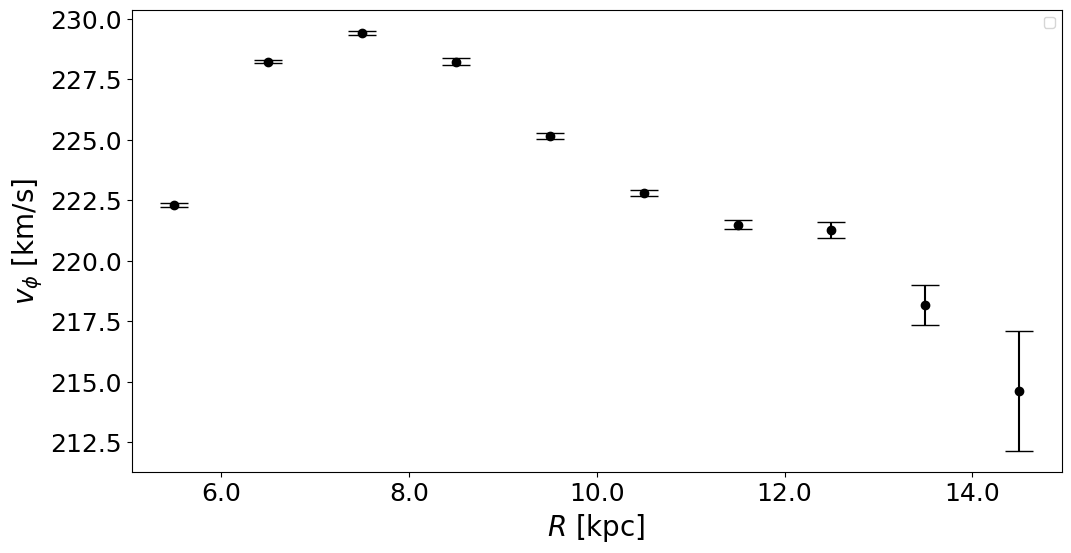

In [10]:
import matplotlib.ticker as ticker

fig, ax = plt.subplots(figsize=(12, 6))

x = np.array(bin_rs)
y = np.array(mean_rot_vel)

ax.scatter(x, -y, color='black')
ax.errorbar(x, -y, 
            yerr=bootstrap_vphi_error, color='black', linestyle='', capsize=10)

def numfmt(x, pos):
            s = '{:.1f}'.format(x / 1000.0)
            return s
fmt = ticker.FuncFormatter(numfmt)
ax.xaxis.set_major_formatter(fmt)
fontdict = {'fontsize' : 20}
ax.set_xlabel(r'$R$ [kpc]', fontdict= fontdict)
ax.set_ylabel(r'$v_\phi$ [km/s]', fontdict= fontdict)

plt.xticks(fontsize=18, rotation=0)
plt.yticks(fontsize=18, rotation=0)
plt.legend()

plt.savefig('mean_rotational_velocities_bootstrap.pdf', dpi = 300, bbox_inches='tight')

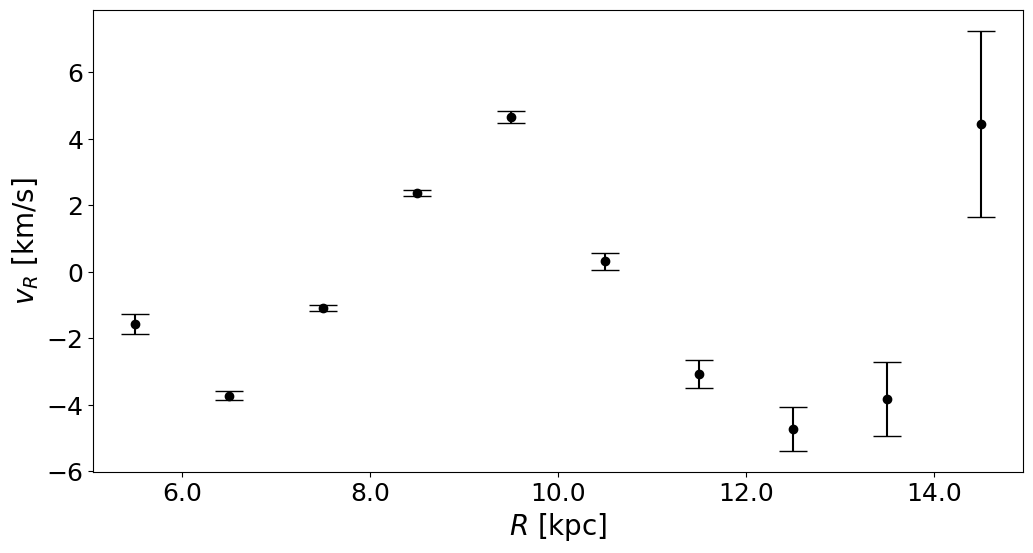

In [11]:
import matplotlib.ticker as ticker

fig, ax = plt.subplots(figsize=(12, 6))

x = np.array(bin_rs)

y = np.array(mean_rad_vel)
ax.scatter(x, -y, color='black', label=r'mean radial velocity ($v_r$)')
ax.errorbar(x, -y, 
            yerr=bootstrap_vr_error, color='black', linestyle='', capsize=10)

def numfmt(x, pos):
            s = '{:.1f}'.format(x / 1000.0)
            return s
fmt = ticker.FuncFormatter(numfmt)
ax.xaxis.set_major_formatter(fmt)
fontdict = {'fontsize' : 20}
ax.set_xlabel(r'$R$ [kpc]', fontdict= fontdict)
ax.set_ylabel(r'$v_R$ [km/s]', fontdict= fontdict)

#ax.hlines(0, 5000, 15000)
plt.xticks(fontsize=18, rotation=0)
plt.yticks(fontsize=18, rotation=0)

plt.savefig('mean_radial_velocities_bootstrap.pdf', dpi = 300, bbox_inches='tight')